In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score, ndcg_score
import plotly.express as px
import random
import warnings
warnings.filterwarnings('ignore')

c:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Airline Demand

In [2]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("datasets/airline_demand/AirPassengers.csv")
data.set_index("Month", inplace=True)
data

,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121
...,...
1960-08,606
1960-09,508
1960-10,461


In [4]:
def sampling(sequence, n_steps):
    X, Y = list(), list()

    for i in range(len(sequence)):
        sam = i + n_steps
        if sam > len(sequence)-1:
            break
        x, y = sequence[i:sam], sequence[sam]
        X.append(x)
        Y.append(y)

    X, y = np.array(X), np.array(Y)
    return X, y

In [5]:
def plot_graph(expected, predicted):
    plt.plot(expected, label="Expected")
    plt.plot(predicted, label="Predicted")
    plt.legend()
    plt.show()

In [6]:
X, y = sampling(data.values.tolist(), 6)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [7]:
model = Sequential()
model.add(LSTM(20, activation='relu', input_shape=(6, 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mae")

In [8]:
model.fit(X, y, epochs=150, batch_size=32, verbose=0)

In [9]:
predictions = model.predict(X, verbose=0)

In [10]:
mean_absolute_percentage_error(y, predictions)

0.0669593243180192

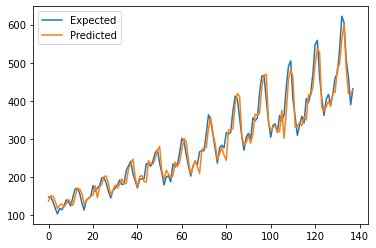

In [11]:
plot_graph(y, predictions)

In [41]:
model.save("model_files/lstm.h5")

# Recommender System

In [ ]:
cities = pd.read_csv('datasets/recommender/city_codes.csv', encoding="latin-1")
cities.loc[cities.destination == "IAH"]

In [2]:
data = [   
    ('user_id', 'airport_id', 'airport', 'region', 'season'),
    # IF u355541 flew 8 times in the summer
        '''
        4 to asia    - then asian summer flights get a  4 - 0.2
        2 to florida - if florida destination is twice, then +0.2
        1 to europe  
        1 to latin
        '''
]

In [3]:
origs = [   
    (1, 'ORD', 'Midwest'),
    (2, 'LAX', 'West'),
    (3, 'SFO', 'West'),
    (4, 'IAH', 'South'),
    (5, 'DEN', 'Snow'),
    (6, 'IAD', 'East'),
    (7, 'EWR', 'East')
]

dests = [
    (1, 'ORD', 'Midwest'),
    (2, 'LAX', 'Sun'),
    (3, 'SFO', 'West'),
    (4, 'IAH', 'Sun'),
    (5, 'DEN', 'Snow'),
    (6, 'IAD', 'East'),
    (7, 'EWR', 'East'),
    (8, 'MCO', 'Sun'),
    (9, 'TPA', 'Sun'),
    (10, 'MIA', 'Sun'),
    (11, 'RSW', 'Sun'),

    # Europe
    (12, 'LHR', 'EURO'),
    (13, 'CVG', 'EURO'),
    (14, 'AMS', 'EURO'),
    (15, 'DUB', 'EURO'),
    (16, 'BRU', 'EURO'),
    (17, 'MUC', 'EURO'),
    (18, 'FRA', 'EURO'),
    (19, 'BHM', 'EURO'),

    # Asia
    (20, 'ICN', 'ASIA'),
    (21, 'NRT', 'ASIA'),
    (22, 'KIX', 'ASIA'),
    (23, 'PVG', 'ASIA'),
    (24, 'HKG', 'ASIA'),
    (25, 'PEK', 'ASIA'),
    (26, 'TPE', 'ASIA'),
    (27, 'SIN', 'ASIA'),

    # Latin America
    (28, 'EZE', 'LAT'),
    (29, 'GRU', 'LAT'),
    (30, 'GIG', 'LAT'),
    (31, 'BOG', 'LAT'),
    (32, 'SCL', 'LAT'),
    (33, 'TGU', 'LAT'),
    (34, 'MEX', 'LAT')
]

In [4]:
# Create an empty DataFrame
data = pd.DataFrame()

# Select amount of random data to generate 
n = 3000

# Append random data to new DataFrame columns
data['user_id'] = [random.choice(range(1,99)) for i in range(n)] 
data['origin_tuple'] = [random.choice(origs) for i in range(n)]
data['destination_tuple'] = [random.choice(dests) for i in range(n)]

# Transform Tuple() items to DataFrame column
data = data.join(pd.DataFrame(data['origin_tuple'].values.tolist(), columns = 
                              ['orig_id', 'orig', 'orig_reg']
                             )
                )
data = data.join(pd.DataFrame(data['destination_tuple'].values.tolist(), columns = 
                              ['dest_id', 'dest', 'dest_reg']
                             )
                )
data = data[[
    'user_id',
    'dest_id',
    'orig',
    'dest',
    'dest_reg'
]]

In [5]:
counts = data.groupby(['user_id', 'dest_reg'], as_index = False)['dest'].count()
counts = counts.rename(columns = {'dest': 'freq'})

data = pd.merge(data, counts, on = ['user_id', 'dest_reg'], how = 'left')

In [ ]:
data.to_csv("datasets/recommender/user_flight_data.csv", index=False)

In [ ]:
# flight_data = pd.read_csv("datasets/recommender/user_flight_data.csv")

In [6]:
import implicit
import scipy.sparse as sparse

'''
The implicit library expects data as a item-user matrix so we create two matricies,
one for fitting the model (item-user) and one for recommendations (user-item)
'''
sparse_item_user = sparse.csr_matrix((data['freq'].astype(float), (data['dest_id'], data['user_id'])))
sparse_user_item = sparse.csr_matrix((data['freq'].astype(float), (data['user_id'], data['dest_id'])))

In [11]:
# Initialize the als model and fit it using the sparse item-user matrix
model = implicit.als.AlternatingLeastSquares(factors = 20, regularization = 0.1, iterations = 20, random_state=1)

# Calculate the confidence by multiplying it by our alpha value.
alpha_val = 15
data_conf = (sparse_user_item * alpha_val).astype('double')

#Fit the model
model.fit(data_conf)

100%|██████████| 20/20 [00:00<00:00, 513.12it/s]


In [12]:
# save model

import pickle
pkl_file = open("pkl_files/ALS.pkl", "wb")
pickle.dump(model, pkl_file)
pkl_file.close()

In [13]:
model = pickle.load(open("pkl_files/ALS.pkl", "rb"))

In [15]:
# Create recommendations for user with id
user_id = int(input('Enter User ID: '))

# Use the implicit recommender
indexes, score = model.recommend(user_id, sparse_user_item[user_id])

airports = []
scores = []

for i in range(len(indexes)):
    if not data.dest.loc[data.user_id == indexes[i]].empty:
        airports.append(data.dest.loc[data.user_id == indexes[i]].iloc[0])
        scores.append(score[i].round(3))

# recommendations = pd.DataFrame({"destination": airports , "score": scores})
recommendations = pd.DataFrame({"destination": airports})
recommendations

,destination
0,KIX
1,EZE
2,FRA
3,BHM
4,EWR
5,IAH
6,LHR
7,LHR
8,LAX
9,BOG


In [ ]:
final = pd.merge(recommendations, cities, on="destination", how="left")
final

# Customer Churn

In [2]:
df_user = pd.read_csv("datasets/customer_churn/users.csv")
df_hotel = pd.read_csv("datasets/customer_churn/hotels.csv")
df_flight = pd.read_csv("datasets/customer_churn/flights.csv")

In [15]:
df_hotel["datetime"] = pd.to_datetime(df_hotel["date"])
df_hotel['monthYear'] = pd.to_datetime(df_hotel['datetime']).dt.to_period('M')
df_hotel['year'] = pd.to_datetime(df_hotel['datetime']).dt.year
df_hotel['month'] = pd.to_datetime(df_hotel['datetime']).dt.month

In [6]:
df_flight["datetime"] = pd.to_datetime(df_flight["date"])
df_flight['monthYear'] = pd.to_datetime(df_flight['datetime']).dt.to_period('M')
df_flight['year'] = pd.to_datetime(df_flight['datetime']).dt.year
df_flight['month'] = pd.to_datetime(df_flight['datetime']).dt.month

In [7]:
df_flight_combine = df_flight.copy()
# Take return ticket's price and date 
df_flight_combine['price_return'] = (df_flight_combine.groupby(['travelCode','userCode'])['price'].shift(-1))
df_flight_combine['date_return'] = (df_flight_combine.groupby(['travelCode','userCode'])['date'].shift(-1))
df_flight_combine["datetime_return"] = pd.to_datetime(df_flight_combine["date_return"])
# Drop one of the combined columns
df_flight_combine = df_flight_combine.dropna(how='any',axis=0)
# Calculate travel date
df_flight_combine['travel_date'] = df_flight_combine.datetime_return - df_flight_combine.datetime
# Extract integer from travel date
df_flight_combine['travel_date_int'] = df_flight_combine['travel_date'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)

In [8]:
df_hotel_join = df_hotel.rename(columns={'name': 'name_hotel', 'days': 'days_hotel', 'total': 'total_hotel'})
df_hotel_join = df_hotel_join[['travelCode', 'userCode','name_hotel','days_hotel','total_hotel']]
# Left join the round flight and hotel
df_flight_hotel = pd.merge(df_flight_combine, df_hotel_join, on=['travelCode', 'userCode'], how='left')
# Create bundle column to distinguish the travellers who booked flight and hotel together
df_flight_hotel['combo'] = 0
df_flight_hotel['combo'] [df_flight_hotel['total_hotel']>0] = 1

In [9]:
df_churned = df_flight_hotel.copy()
# If it is the agency's first year order (since 2019/10~2020/09) then label it as old order.
conditions = [(df_churned['datetime'] >= '10/01/2019') &  (df_churned['datetime'] <= '09/30/2020')]
df_churned['orderOld'] = np.select(conditions, '1', default='0')
# If it is the agency's second year order (since 2020/10~2021/09) then label it as new order.
conditions = [(df_churned['datetime'] >= '10/01/2020') &  (df_churned['datetime'] <= '09/30/2021')]
df_churned['orderNew'] = np.select(conditions, '1', default='0')
# Str to Int
df_churned['orderNew']=df_churned['orderNew'].astype(int)
df_churned['orderOld']=df_churned['orderOld'].astype(int)

In [10]:
# Group by the users to calculate how many old orders and new orders if person has each.
df_churned_groupby = df_churned.groupby(['userCode']).sum()
# Reset the index
df_churned_groupby = df_churned_groupby.reset_index()
# Add a new column to calculate the old and new orders in total.
df_churned_groupby['orderSum'] = df_churned_groupby['orderNew'] + df_churned_groupby['orderOld']

In [11]:
# Categorized customer status into "new","continued", "churned"
df_churned_groupby['userStatus'] = 0
df_churned_groupby['userStatus'] [(df_churned_groupby['orderOld'] > 0)&(df_churned_groupby['orderNew'] > 0) ] = 'continued'
df_churned_groupby['userStatus'] [(df_churned_groupby['orderOld'] == 0)&(df_churned_groupby['orderNew'] > 0) ] = 'new'
df_churned_groupby['userStatus'] [(df_churned_groupby['orderOld'] > 0)&(df_churned_groupby['orderNew'] == 0) ] = 'churned'

In [16]:
df_flight = df_flight.loc[(df_flight['monthYear'] >= '2019-10') & (df_flight['monthYear'] <= '2020-09')]
df_hotel = df_hotel.loc[(df_hotel['monthYear'] >= '2019-10') & (df_hotel['monthYear'] <= '2020-09')]

In [17]:
#Step 1 - Combine the round tickets into one.  
df_flight_combine = df_flight.copy()
# Take return ticket's price and date 
df_flight_combine['price_return'] = (df_flight_combine.groupby(['travelCode','userCode'])['price'].shift(-1))
df_flight_combine['date_return'] = (df_flight_combine.groupby(['travelCode','userCode'])['date'].shift(-1))
df_flight_combine["datetime_return"] = pd.to_datetime(df_flight_combine["date_return"])
# Drop one of the combined columns
df_flight_combine = df_flight_combine.dropna(how='any',axis=0)
# Calculate travel date
df_flight_combine['travel_date'] = df_flight_combine.datetime_return - df_flight_combine.datetime
# Extract integer from travel date
df_flight_combine['travel_date_int'] = df_flight_combine['travel_date'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)
# Create pseudo column to count 
df_flight_combine['ticketCount'] = 1

In [18]:
df_hotel_join = df_hotel.rename(columns={'name': 'name_hotel', 'days': 'days_hotel', 'total': 'total_hotel'})
df_hotel_join = df_hotel_join[['travelCode', 'userCode','name_hotel','days_hotel','total_hotel']]
# Left join the round flight and hotel
df_flight_hotel = pd.merge(df_flight_combine, df_hotel_join, on=['travelCode', 'userCode'], how='left')
# Create bundle column to distinguish the travller who booked flight and hotel together
df_flight_hotel['combo'] = 0
df_flight_hotel['combo'] [df_flight_hotel['total_hotel']>0] = 1

In [19]:
df_flight_hotel.groupby('userCode').sum().reset_index()

,userCode,travelCode,price,time,distance,year,month,price_return,travel_date_int,ticketCount,days_hotel,total_hotel,combo
0,0,1378,51614.00,72.86,28026.44,105027,334,48116.08,129,52,39.0,9076.28,16
1,1,460,3875.04,6.49,2496.15,10095,50,4183.69,5,5,2.0,386.72,2
2,2,6318,47779.93,70.81,27242.91,105027,334,45896.92,141,52,42.0,8052.44,15
3,3,13130,48418.45,67.25,25872.46,105027,334,47954.19,115,52,33.0,8082.12,15
4,4,23478,51739.36,72.17,27764.89,105027,334,48018.74,127,52,30.0,6282.96,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,1335,7055750,44052.28,87.41,33655.36,105027,334,60365.39,130,52,35.0,6375.98,16
1320,1336,407583,2326.35,4.53,1741.42,6057,30,3210.53,9,3,2.0,495.24,1
1321,1337,3940462,26603.98,49.95,19227.59,58567,179,33003.43,73,29,31.0,7303.90,11
1322,1338,815379,5356.01,10.77,4139.76,12114,61,6700.53,19,6,4.0,990.48,1


In [20]:
df_user_record = df_flight_hotel.groupby('userCode').sum().reset_index()
# Take useful record from df_flight_hotel's numerical data
df_user_record = df_user_record[['userCode','ticketCount','price','price_return','distance','travel_date_int','days_hotel','total_hotel','combo']]
# User list with userStatus (churned or continued) from the previous section "Transform from Order Dimension to Customer Dimension
df_churned_list = df_churned_groupby[['userCode','userStatus']]
# Join the above two dataframes
df_customer = pd.merge(df_user_record,df_churned_list,on=['userCode'],how='left')
# Rename the columns in df_user in case misunderstanding
df_user_join = df_user.rename(columns={'code': 'userCode', 'company': 'userCompany', 'name': 'userName'})
# Join the above two dataframes
df_customer = pd.merge(df_customer,df_user_join,on=['userCode'],how='left')

In [21]:
df_customer['flightPriceDiffer'] = df_customer['price_return'] - df_customer['price']
df_customer['flightPriceSum'] = df_customer['price_return'] + df_customer['price']
df_customer['flightPriceDistanceAvg'] = df_customer['flightPriceSum']/df_customer['distance']
df_customer['hotelPriceDayAvg'] = df_customer['total_hotel']/df_customer['days_hotel']
df_customer['flightPriceDifferDistanceAvg'] = df_customer['flightPriceDiffer']/df_customer['distance']
df_customer['flightPriceDifferTicketAvg'] = df_customer['flightPriceDiffer']/df_customer['ticketCount']
df_customer['flightPriceTicketAvg'] = df_customer['flightPriceSum']/df_customer['ticketCount']
df_customer['comboFrequency'] = df_customer['combo']/df_customer['ticketCount']
df_customer['hotelStayDayAvg'] = df_customer['days_hotel']/df_customer['combo']

# Unify the form of name
df_customer = df_customer.rename(columns={'price': 'flightPriceGo', 
                                       'price_return': 'flightPriceReturn',
                                       'distance': 'flightDistance',
                                       'travel_date_int':'travelDays',
                                       'days_hotel':'hotelDays',
                                        'total_hotel':'hotelPrice'
                                      })

In [22]:
df_customer['userStatus01'] = 0
df_customer['userStatus01'] [df_customer['userStatus'] == 'churned'] = 1
df_customer['hotelPriceDayAvg'] = df_customer['hotelPriceDayAvg'].fillna(0)
df_customer['hotelStayDayAvg'] = df_customer['hotelStayDayAvg'].fillna(0)

In [23]:
df_customer.isnull().sum()

userCode                        0
ticketCount                     0
flightPriceGo                   0
flightPriceReturn               0
flightDistance                  0
travelDays                      0
hotelDays                       0
hotelPrice                      0
combo                           0
userStatus                      0
userCompany                     0
userName                        0
gender                          0
age                             0
flightPriceDiffer               0
flightPriceSum                  0
flightPriceDistanceAvg          0
hotelPriceDayAvg                0
flightPriceDifferDistanceAvg    0
flightPriceDifferTicketAvg      0
flightPriceTicketAvg            0
comboFrequency                  0
hotelStayDayAvg                 0
userStatus01                    0
dtype: int64

In [28]:
predictors = [
# 'ticketCount',
'flightPriceGo',
'flightPriceReturn',
'flightDistance',
'travelDays',
'hotelDays',
'hotelPrice',
'combo',
'age',
# 'flightPriceSum',
# 'flightPriceDistanceAvg',
# 'hotelPriceDayAvg',
# 'flightPriceDiffer',
# 'flightPriceDifferDistanceAvg',
# 'flightPriceDifferTicketAvg',
# 'flightPriceTicketAvg',
'comboFrequency',
'hotelStayDayAvg',
# 'userCompany'
# 'userStatus',
# 'userName',
# 'gender',
# 'ageRange',
]
outcome = 'userStatus01'
X = pd.get_dummies(df_customer[predictors], prefix='', prefix_sep='')
y = df_customer[outcome]

In [25]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=777)
X_res, y_res = rus.fit_resample(X,y)
df_X_res = pd.DataFrame(X_res)
df_y_res = pd.DataFrame(y_res)
df_resample = pd.concat([df_X_res, df_y_res], axis=1)

In [27]:
# imbalance fixed
df_resample.userStatus01.value_counts()

0    353
1    353
Name: userStatus01, dtype: int64

In [40]:
predictors = [
'ticketCount',
'flightPriceGo',
'flightPriceReturn',
'flightDistance',
'travelDays',
'hotelDays',
'hotelPrice',
'combo',
'age',
# 'flightPriceSum',
# 'flightPriceDistanceAvg',
# 'hotelPriceDayAvg',
# 'flightPriceDiffer',
# 'flightPriceDifferDistanceAvg',
# 'flightPriceDifferTicketAvg',
# 'flightPriceTicketAvg',
'comboFrequency',
'hotelStayDayAvg',
# '4You',
# 'Acme Factory',
# 'Monsters CYA',
# 'Umbrella LTDA',
# 'Wonka Company'
]
outcome = 'userStatus01'
X = df_resample[predictors]
y = df_resample[outcome]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [42]:
params ={ 'booster':'gbtree',
         'eval_metric': 'auc', #'rmse'
         'max_depth': 5,
         'min_child_weight':20, 
         'gamma':0, 
         'subsample':0.8,
         'colsample_bytree':0.8,
         'eta':0.01,  
         'random_state':7,
        }
xgb = XGBClassifier(**params)
xgb.fit(X_train, y_train)
train_accuracy_score = accuracy_score(xgb.predict(X_train), y_train)
test_accuracy_score = accuracy_score(xgb.predict(X_test), y_test)
train_accuracy_score, test_accuracy_score

(0.9858299595141701, 0.9858490566037735)

In [70]:
X_train.iloc[0]

ticketCount             52.000000
flightPriceGo        45139.750000
flightPriceReturn    44700.990000
flightDistance       22195.940000
travelDays             122.000000
hotelDays               33.000000
hotelPrice            6589.800000
combo                   15.000000
age                     57.000000
comboFrequency           0.288462
hotelStayDayAvg          2.200000
Name: 103, dtype: float64

In [69]:
X_train.iloc[1]

ticketCount             38.000000
flightPriceGo        32576.270000
flightPriceReturn    29459.470000
flightDistance       16490.200000
travelDays              85.000000
hotelDays               15.000000
hotelPrice            3204.680000
combo                    6.000000
age                     64.000000
comboFrequency           0.157895
hotelStayDayAvg          2.500000
Name: 544, dtype: float64

In [58]:
to_predict = pd.DataFrame({
    "ticketCount": [X_train.iloc[0].values[0]],
    "flightPriceGo": [X_train.iloc[0].values[1]],
    "flightPriceReturn": [X_train.iloc[0].values[2]],
    "flightDistance": [X_train.iloc[0].values[3]],
    "travelDays": [X_train.iloc[0].values[4]],
    "hotelDays": [X_train.iloc[0].values[5]],
    "hotelPrice": [X_train.iloc[0].values[6]],
    "combo": [X_train.iloc[0].values[7]],
    "age": [X_train.iloc[0].values[8]],
    "comboFrequency": [X_train.iloc[0].values[9]],
    "hotelStayDayAvg": [X_train.iloc[0].values[10]],
}) 

In [71]:
to_predict2 = pd.DataFrame({
    "ticketCount": [X_train.iloc[1].values[0]],
    "flightPriceGo": [X_train.iloc[1].values[1]],
    "flightPriceReturn": [X_train.iloc[1].values[2]],
    "flightDistance": [X_train.iloc[1].values[3]],
    "travelDays": [X_train.iloc[1].values[4]],
    "hotelDays": [X_train.iloc[1].values[5]],
    "hotelPrice": [X_train.iloc[1].values[6]],
    "combo": [X_train.iloc[1].values[7]],
    "age": [X_train.iloc[1].values[8]],
    "comboFrequency": [X_train.iloc[1].values[9]],
    "hotelStayDayAvg": [X_train.iloc[1].values[10]],
}) 

In [72]:
xgb.predict(to_predict2)[0]

1

In [74]:
xgb = pickle.load(open("pkl_files/XGBoost_churn.pkl", "rb"))
xgb.predict(to_predict2)[0]

1

In [53]:
# save model

import pickle
pkl_file = open("pkl_files/XGBoost_churn.pkl", "wb")
pickle.dump(xgb, pkl_file)
pkl_file.close()

# Airbnb Dataset

In [ ]:
train_df = pd.read_csv("datasets/airbnb/train_users_2.csv")
test_df = pd.read_csv("datasets/airbnb/test_users.csv")
train_df.shape, test_df.shape

In [ ]:
train_df.head()

In [ ]:
# Drop id column
train_df.drop(columns="id", inplace=True)

In [ ]:
for data in [train_df, test_df]:
    data.date_account_created = pd.to_datetime(data['date_account_created'])
    data['account_year'] = data.date_account_created.dt.year
    data['account_month'] = data.date_account_created.dt.month
    data['account_day'] = train_df.date_account_created.dt.day

In [ ]:
train_df = train_df[['timestamp_first_active',
 'gender',
 'age',
 'signup_method',
 'signup_flow',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'signup_app',
 'first_device_type',
 'first_browser',
 'account_year',
 'account_month',
 'account_day','country_destination']]

test_df = test_df[['timestamp_first_active',
 'gender',
 'age',
 'signup_method',
 'signup_flow',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'signup_app',
 'first_device_type',
 'first_browser',
 'account_year',
 'account_month',
 'account_day']]

In [ ]:
for data in [train_df,test_df]:
    data.age = data.age.apply(lambda x: np.nan if x<18 else x)
    data.age = data.age.apply(lambda x: np.nan if x>100 else x)

In [ ]:
# replace nan age values with mean age
for data in [train_df,test_df]:
    data.age.fillna(data.age.mean(),inplace=True)

In [ ]:
# check for any nan values after pre-processing
train_df.isna().sum()

In [ ]:
def remove_outliers(df, name="feature"):
    #Store the 25th and 75th percentile 
    q25,q75 = np.percentile(df[name],25), np.percentile(df[name],75)
    #Calculate the Interquartile range
    iqr_cut = 1.5*(q75-q25)
    #Create variable of lower and upper cut
    lower,upper = q25-iqr_cut, q75+iqr_cut
    #Remove the outliers
    df = df[(df[name] >= lower) & (df[name] <= upper)]
    return df

In [ ]:
train = train_df.copy()
train = remove_outliers(train,'age')

# Define inputs and target cols
inputs_col = train.columns[:-1]
target_col = ['country_destination']

# Define inputs
inputs = train[inputs_col].copy()
target = train[target_col].copy()

# Define numerical and categorical columns
numerical_cols = inputs.select_dtypes(include=['int64','float64']).columns.to_list()
categorical_cols = inputs.select_dtypes(include='object').columns.to_list()

# Normalization
scaler = MinMaxScaler().fit(inputs[numerical_cols])
inputs[numerical_cols] = scaler.transform(inputs[numerical_cols])

# label encoding
for col in categorical_cols:
    # label encoding
    encoder = LabelEncoder().fit(inputs[col])
    inputs[col] = encoder.transform(inputs[col])
    
enc_countries = {'NDF':0,'US':1,'FR':2,'CA':3,'GB':4,'ES':5,'IT':6,'PT':7,'NL':8,'DE':9,'AU':10,'other':11}
target['country_destination'] = target['country_destination'].apply(lambda x:enc_countries[x])


# Define X variable
X = inputs[numerical_cols + categorical_cols]
# Define y variable
y = target['country_destination']

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

In [ ]:
print('X_train:', len(X_train))
print('y_train:', len(y_train))
print('X_val:', len(X_test))
print('y_train:', len(y_test))

In [ ]:
xgb = XGBClassifier(random_state=3, n_jobs=-1, max_depth=3, n_estimators=100, objective='multi:softprob', learning_rate=0.3, use_label_encoder=False)
xgb.fit(X_train, y_train, eval_metric="merror")
train_accuracy_score = accuracy_score(xgb.predict(X_train), y_train)
test_accuracy_score = accuracy_score(xgb.predict(X_test), y_test)
train_ndcg_score = ndcg_score(pd.get_dummies(y_train).to_numpy(), xgb.predict_proba(X_train))
test_ndcg_score = ndcg_score(pd.get_dummies(y_test).to_numpy(), xgb.predict_proba(X_test))

In [ ]:
train_accuracy_score, test_accuracy_score, train_ndcg_score, test_ndcg_score

In [ ]:
xgb_importance_df = pd.DataFrame({'features': X.columns,
                  'importance': xgb.feature_importances_}).sort_values('importance',ascending=True)

In [ ]:
px.bar(xgb_importance_df, x='importance', y='features')

In [ ]:
# save model

import pickle
pkl_file = open("pkl_files/XGBoost_airbnb.pkl", "wb")
pickle.dump(xgb, pkl_file)
pkl_file.close()